In [1]:
import math
import numpy as np
import pandas as pd
from ces_direct_energy_utils import *

In [2]:
## scenario switch
case=3 # 2 means no trade in goods; 3 means trade in both energy and goods
logit = 0 # 1 means logit estimations of supply elasticity; 0 means fixed elasticities

## parameter values
theta = 4             # scopevec for comparative advantage
sigma = 1      # elasticity of demand for each individual manufactured good j at Home
sigmastar = 1  # elasticity of demand for each individual manufactured good j at Foreign
sigmaE = 1
sigmaEstar = 1

# beta gamma not used in the code unless logit indicated
beta=1.892412
gamma=0.807998928

In [3]:
# carbon content per unit of energy
h1 = 1
h2 = 0

# elasticity of supply of renewables
epsilonSstar1 = 0.5
epsilonS1 = 0.5
epsilonSstar2 = 0.5
epsilonS2 = 0.5

# make sure that epsilonSvec and epsilonSstarvec have equal length
# if a country does not have that energy source, set proportion to 0
epsilonSvec = [(epsilonS1, 1, 0.867), (epsilonS2, h2, 0.133)]
epsilonSstarvec = [(epsilonSstar1, 1,0.867), (epsilonSstar2, h2, 0.133)]

# baseline, no renewable energy
epsilonSvec = [(epsilonS1, h1, 1), (epsilonS2, h2, 0)]
epsilonSstarvec = [(epsilonSstar1, h1, 1), (epsilonSstar2, h2, 0)]
assert(sum(k for i,j,k in epsilonSvec) == 1)
assert(sum(k for i,j,k in epsilonSstarvec) == 1)

In [4]:
## import BAU values (seven regional scenarios in the order of US, EU, OECD, World, China, OECD plus China)
if case==2:
    df = pd.read_csv("../../raw_data/BaselineCarbon_2015_noTradeinGoods.csv",index_col=['region_scenario','regionbase'],header='infer')
elif case==3:
    # comment out if running simulation with no renewables
    #df = pd.read_csv("../../raw_data/BaselineCarbon_2015.csv", index_col=['regionbase'],header='infer')
    df = pd.read_csv("../../raw_data/BaselineCarbon_direct_cons.csv", index_col=['regionbase'],header='infer')
df['jxbar']=df['CeFH']/(df['CeFH'] + df['CeFF'])
df['jmbar']=df['CeHH']/(df['CeHH'] + df['CeHF'])

## choose which regional scenario to run (runs all if not executed)
#df=df.drop([2,3,4,5,6,7])  
df = df[df['region_scenario'] == 3]
#df = df[df['region_scenario'] != 4]
df

,region_scenario,Qe,Qestar,Qeworld,CeHH_old,CeHF,CeFH,CeFF_old,Ce,Cestar,...,Gestar,Ceworld,Geworld,Unnamed: 15,Cec,Cecstar,CeHH,CeFF,jxbar,jmbar
regionbase,,,,,,,,,,,,,,,,,,,,,
OECD37 as Home,3,8.62549,23.6505,32.27599,11.29367,2.48754,0.91057,17.58421,13.78121,18.49478,...,14.795824,32.27599,32.27599,NaN,2.756242,3.698956,8.537428,13.885254,0.061542,0.774372


In [5]:
#tax_scenario= pd.DataFrame({'tax_sce': ['Unilateral','global','purete','puretc','puretp','EC_hybrid','EP_hybrid','PC_hybrid','EPC_hybrid'], 'Base':[0,1,1,1,1,1,1,1,1]},index=[1,2, 3, 4, 5, 6, 7, 8,9])
#tax_scenario= pd.DataFrame({'tax_sce': ['Unilateral','purete','puretc','puretp','EC_hybrid','EP_hybrid','PC_hybrid','EPC_hybrid'], 'Base':[0,1,1,1,1,1,1,1]},index=[1,2, 3, 4, 5, 6, 7, 8])
#tax_scenario= pd.DataFrame({'tax_sce': ['PC_hybrid'], 'Base':[1]},index=[1])
tax_scenario= pd.DataFrame({'tax_sce': ['purete','puretc','puretp'], 'Base':[1,1,1]},index=[1,2, 3])

In [6]:
def iterate_tax(tax_scenario,df,theta, sigma, sigmastar, sigmaC, sigmaCstar, epsilonSvec, epsilonSstarvec, beta, gamma, logit):
    paralist = (theta, sigma, sigmastar, sigmaE, sigmaEstar, epsilonSvec, epsilonSstarvec, beta, gamma, logit)
    varphilist = np.arange(0,3,0.1)
    #varphilist = np.arange (0,1,0.2)
    varphilist = [0,1,2]
    output=[]
    prevtb = []
    for varphi in varphilist:    
        tax_df=df.apply(iterate_region, axis=1, raw=False, args=(prevtb, varphi, tax_scenario, paralist))
        prevtb = tax_df[['region_scenario','tb', 'pe', 'te', 'prop']]
        output.append(tax_df)
        print(varphi)
        
    output = pd.concat(output, axis=0, join='outer',  ignore_index=False, keys=None, levels=None, names=None, verify_integrity=False,copy=True)
    output.reset_index(level=0, inplace=True)
    output = output.sort_values(by=['region_scenario','varphi'])
    
    # if extraction tax too large home stops extracting
    if tax_scenario['tax_sce']=='purete' or tax_scenario['tax_sce']=='EP_hybrid' or tax_scenario['tax_sce'] == 'Unilateral':
        output.te[output.Qe_prime==0]=output.pe+output.tb
    print(tax_scenario['tax_sce'])
    return output

In [7]:
def iterate_region(df, prevtb, varphi, tax_scenario, paralist):
    # initial guess if previous value isn't available
    pe = 1
    te = 0.5
    tb_mat = [0,0.5]
    
    # use previous vector of solution if available
    if (type(prevtb) != list):
        curr_region = prevtb[prevtb['region_scenario'] == df['region_scenario']]
        vals = curr_region.values
        tb_mat = [vals[0][1], vals[0][4]]
        pe = vals[0][2]
        te = vals[0][3]
    tax_temp = tax_eq(pe, te, tb_mat, df, tax_scenario, varphi, paralist)
    tax_temp.opt_tax()
    ret = tax_temp.retrieve()
    return ret

In [8]:
temp_df = tax_scenario.apply(iterate_tax, axis=1, args=(df,theta, sigma, sigmastar, sigmaE, sigmaEstar, epsilonSvec, epsilonSstarvec, beta, gamma, logit))

0
1
2
purete


C:\Users\Alex\Desktop\Tobin\sam\Optimal-Unilateral-Carbon-Policy\simulation_results\codes\direct_energy_consumption\ces_direct_energy_utils.py:627: RuntimeWarning: invalid value encountered in double_scalars
  leakage1 = -(Qestar_prime - df['Qestar']) / (Qeworld_prime - df['Qeworld'])
C:\Users\Alex\Desktop\Tobin\sam\Optimal-Unilateral-Carbon-Policy\simulation_results\codes\direct_energy_consumption\ces_direct_energy_utils.py:628: RuntimeWarning: divide by zero encountered in double_scalars
  leakage2 = -(Gestar_prime - df['Gestar']) / (Qeworld_prime - df['Qeworld'])
C:\Users\Alex\Desktop\Tobin\sam\Optimal-Unilateral-Carbon-Policy\simulation_results\codes\direct_energy_consumption\ces_direct_energy_utils.py:629: RuntimeWarning: invalid value encountered in double_scalars
  leakage3 = -(Cestar_prime - df['Cestar']) / (Qeworld_prime - df['Qeworld'])
C:\Users\Alex\Desktop\Tobin\sam\Optimal-Unilateral-Carbon-Policy\simulation_results\codes\direct_energy_consumption\ces_direct_energy_utils.p

0
1
2
puretc
0
1
2
puretp


In [9]:
output_list=[]
for i in range(1,len(tax_scenario)+1):
    output_list.append(temp_df.loc[i])
Outcomes = pd.concat(output_list, axis=0, join='outer', ignore_index=False, keys=tax_scenario['tax_sce'], levels=None, verify_integrity=False,copy=True)
Outcomes.reset_index(level=0, inplace=True)
Outcomes

,tax_sce,regionbase,varphi,pe,tb,prop,te,jxbar_prime,jmbar_prime,j0_prime,...,delta_Vg,delta_Vgstar,welfare,welfare_noexternality,Qe1_prime,Qe1star_prime,Qe2_prime,Qe2star_prime,region_scenario,conv
0,purete,OECD37 as Home,0.0,1.000000,0.000000,1.000000,0.000000,0.061542,0.774372,0.061542,...,-0.000001,-0.000001,-4.471499e-06,-4.471499e-06,8.625490,23.650501,0.0,0.0,3.0,1.0
1,purete,OECD37 as Home,1.0,1.064466,0.000000,1.000000,0.593349,0.061542,0.774372,0.061542,...,-0.860961,-1.155435,7.684106e-01,-1.359163e+00,5.920362,24.400925,0.0,0.0,3.0,1.0
2,purete,OECD37 as Home,2.0,1.165564,0.000000,1.000000,1.102975,0.061542,0.774372,0.061542,...,-2.111356,-2.833501,4.385245e+00,-5.595069e+00,2.157907,25.533389,0.0,0.0,3.0,1.0
0,puretc,OECD37 as Home,0.0,1.000000,0.000000,0.500000,0.000000,0.061542,0.774372,0.061542,...,-0.000000,-0.000000,-1.546764e-14,-1.546764e-14,8.625490,23.650500,0.0,0.0,3.0,1.0
1,puretc,OECD37 as Home,1.0,0.889271,0.540471,0.118226,0.540471,0.061542,0.774372,0.047002,...,-4.926700,2.170422,2.920772e-01,-1.709947e+00,8.133938,22.302698,0.0,0.0,3.0,1.0
2,puretc,OECD37 as Home,2.0,0.836233,1.026538,0.068999,1.026538,0.061542,0.774372,0.038976,...,-8.572811,3.307765,1.888883e+00,-4.121407e+00,7.887644,21.627377,0.0,0.0,3.0,1.0
0,puretp,OECD37 as Home,0.0,1.000000,0.000000,0.500000,0.000000,0.061542,0.774372,0.061542,...,-0.000000,-0.000000,-1.546764e-14,-1.546764e-14,8.625490,23.650500,0.0,0.0,3.0,1.0
1,puretp,OECD37 as Home,1.0,0.964925,0.158194,1.000000,0.158194,0.056487,0.758061,0.056487,...,-1.111152,0.494745,3.567550e-01,-2.648396e-01,8.472871,23.232030,0.0,0.0,3.0,1.0
2,puretp,OECD37 as Home,2.0,0.949982,0.240787,1.000000,0.240787,0.054164,0.749814,0.054164,...,-1.665968,0.707587,1.286815e+00,-4.928633e-01,8.407010,23.051443,0.0,0.0,3.0,1.0


In [10]:
Outcomes[['pe','tb', 'Cec_prime', 'Cecstar_prime', 'Cey_prime', 'Cex_prime', 'Cem_prime', 'Ceystar_prime', 'Vgx_prime', 'Vgm_prime']]

,pe,tb,Cec_prime,Cecstar_prime,Cey_prime,Cex_prime,Cem_prime,Ceystar_prime,Vgx_prime,Vgm_prime
0,1.000000,0.000000,2.756242,3.698956,8.537427,0.910570,2.487540,13.885253,6.070467,16.583600
1,1.064466,0.000000,2.589318,3.474939,8.020383,0.855424,2.336889,13.044334,6.070467,16.583600
2,1.165564,0.000000,2.364727,3.173532,7.324716,0.781227,2.134194,11.912902,6.070467,16.583600
0,1.000000,0.000000,2.756242,3.698956,8.537428,0.910570,2.487540,13.885254,6.070467,16.583600
1,0.889271,0.540471,1.927790,4.159537,5.971307,1.023951,1.739852,15.614198,6.070467,16.583600
2,0.836233,1.026538,1.479646,4.423358,4.583187,1.088896,1.335398,16.604537,6.070467,16.583600
0,1.000000,0.000000,2.756242,3.698956,8.537428,0.910570,2.487540,13.885254,6.070467,16.583600
1,0.964925,0.158194,2.454096,3.833412,7.441415,0.744152,2.764331,14.467497,5.571807,20.697816
2,0.949982,0.240787,2.314672,3.893710,6.942291,0.673007,2.903524,14.731249,5.342641,23.049529


In [11]:
#outcome_t = Outcomes[Outcomes['regionbase'] == 'US as Home']
Outcomes[['pe','tb', 'Qe_prime', 'Qestar_prime','Lg_prime','Lgstar_prime', 'Vg_prime', 'Vgstar_prime', 'Vgx2_prime', 'delta_Le','delta_Lestar','welfare','welfare_noexternality']]

,pe,tb,Qe_prime,Qestar_prime,Lg_prime,Lgstar_prime,Vg_prime,Vgstar_prime,Vgx2_prime,delta_Le,delta_Lestar,welfare,welfare_noexternality
0,1.000000,0.000000,8.625490,23.650501,53.538655,92.779166,73.499787,62.986653,0.000000,3.229048e-07,8.853828e-07,-4.471499e-06,-4.471499e-06
1,1.064466,0.000000,5.920362,24.400925,53.538655,92.779166,73.499787,62.986653,0.000000,-1.945435e+00,7.744875e-01,7.684106e-01,-1.359163e+00
2,1.165564,0.000000,2.157907,25.533389,53.538655,92.779166,73.499787,62.986653,0.000000,-2.830143e+00,2.036770e+00,4.385245e+00,-5.595069e+00
0,1.000000,0.000000,8.625490,23.650500,53.538655,92.779166,73.499787,62.986653,0.000000,0.000000e+00,0.000000e+00,-1.546764e-14,-1.546764e-14
1,0.889271,0.540471,8.133938,22.302698,53.538655,92.779166,54.597794,41.471200,1.434234,-4.640716e-01,-1.272452e+00,2.920772e-01,-1.709947e+00
2,0.836233,1.026538,7.887644,21.627377,53.538655,92.779166,45.395921,31.621201,2.225945,-6.765285e-01,-1.854995e+00,1.888883e+00,-4.121407e+00
0,1.000000,0.000000,8.625490,23.650500,53.538655,92.779166,73.499787,62.986653,0.000000,0.000000e+00,0.000000e+00,-1.546764e-14,-1.546764e-14
1,0.964925,0.158194,8.472871,23.232030,52.095744,94.222077,76.415120,53.441204,0.000000,-1.499341e-01,-4.111091e-01,3.567550e-01,-2.648396e-01
2,0.949982,0.240787,8.407010,23.051443,51.385714,94.932108,78.160669,49.309669,0.000000,-2.129927e-01,-5.840114e-01,1.286815e+00,-4.928633e-01


In [12]:
#Outcomes.to_csv('../../output_renewable/direct_consumption.csv'.format(theta, case), header=True)

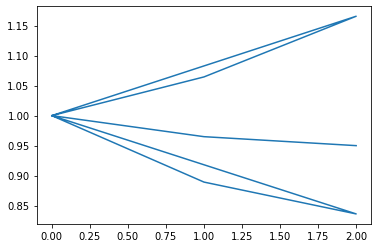

In [13]:
import matplotlib.pyplot as plt
plt.plot(Outcomes['varphi'], Outcomes['pe'])

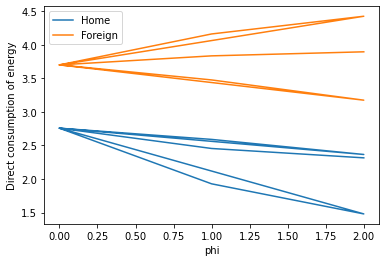

In [14]:
plt.plot(Outcomes['varphi'], Outcomes['Cec_prime'], label = "Home")
plt.plot(Outcomes['varphi'], Outcomes['Cecstar_prime'], label = "Foreign")
plt.xlabel("phi")
plt.ylabel("Direct consumption of energy")
plt.legend()
#plt.savefig('phi_cec.pdf', format='PDF')

In [15]:
Outcomes['petb'] = Outcomes['pe'] + Outcomes['tb']

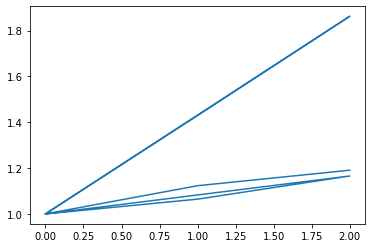

In [16]:
plt.plot(Outcomes['varphi'], Outcomes['petb'])

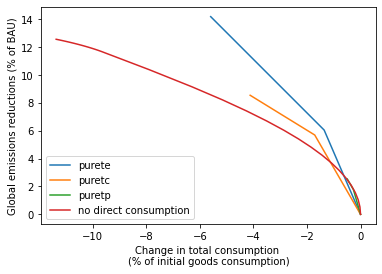

In [17]:
df = pd.read_csv('../../output/output_case3.csv')
df = df[(df['region_scenario'] == 1) & (df['tax_sce'] == 'Unilateral') & (df['varphi'] <= 3)]
Outcomes['Qeworld_chg']=-(Outcomes['Qeworld_prime']-32.2760)/32.2760*100

df_plot = Outcomes[Outcomes['tax_sce'] == 'purete']  
plt.plot(df_plot['welfare_noexternality'], df_plot['Qeworld_chg'], label = 'purete')

df_plot = Outcomes[Outcomes['tax_sce'] == 'puretc']  
plt.plot(df_plot['welfare_noexternality'], df_plot['Qeworld_chg'], label = 'puretc')

df_plot = Outcomes[Outcomes['tax_sce'] == 'puretp']  
plt.plot(df_plot['welfare_noexternality'], df_plot['Qeworld_chg'], label = 'puretp')

df['Qeworld_chg']=-(df['Qeworld_prime']-32.2760)/32.2760*100
plt.plot(df['welfare_noexternality'], df['Qeworld_chg'], label = 'no direct consumption')

plt.xlabel('Change in total consumption \n(% of initial goods consumption)')
plt.ylabel('Global emissions reductions (% of BAU)')
plt.legend()

#plt.savefig('wf_chg.pdf', format = 'PDF')

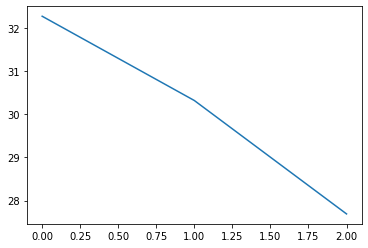

In [19]:
df_plot = Outcomes[Outcomes['tax_sce'] == 'purete']  
plt.plot(df_plot['varphi'], df_plot['Qeworld_prime'], label = 'purete')